<a href="https://colab.research.google.com/github/AntoineYK/tp-colab/blob/main/tp2_antoineMerle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2

## 1. Prise en main: Préparation des données

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, round, split, explode, regexp_replace, when, ceil, col, to_date
import missingno as msno
import matplotlib.pyplot as plt

#### Initialiser la session Spark

In [2]:
spark = SparkSession.builder.appName("MoviesData").getOrCreate()

#### Charger le fichier CSV dans un DataFrame

In [3]:
file_path = "netflix1.csv"
df = spark.read.option("header", "true").csv(file_path)

In [ ]:
df.show(10)

#### Supprimer les lignes contenant des valeurs nulles


In [22]:
valeurs = ["Not Given", "N/A", "Unknown", ""]

df_clean = df.select(
    [when(col(c).isin(valeurs), None).otherwise(col(c)).alias(c) for c in df.columns]
)

# Afficher les résultats
df_clean.show(truncate=False)

+-------+-------+--------------------------------+-------------------------------+--------------+----------+------------+------+---------+-------------------------------------------------------------+
|show_id|type   |title                           |director                       |country       |date_added|release_year|rating|duration |listed_in                                                    |
+-------+-------+--------------------------------+-------------------------------+--------------+----------+------------+------+---------+-------------------------------------------------------------+
|s1     |Movie  |Dick Johnson Is Dead            |Kirsten Johnson                |United States |9/25/2021 |2020        |PG-13 |90 min   |Documentaries                                                |
|s3     |TV Show|Ganglands                       |Julien Leclercq                |France        |9/24/2021 |2021        |TV-MA |1 Season |Crime TV Shows, International TV Shows, TV Action & Advent

## 2. Visualisation des données manquantes

#### Convertir temporairement le DataFrame PySpark en DataFrame *Pandas*

In [ ]:
# Fraction approximative pour obtenir un échantillon de 1000 lignes
fraction = 1000 / df_clean.count()

#Réduire le tableau à 1000 lignes pour limiter l'utilisation de la mémoire
df_sample = df_clean.sample(withReplacement=False, fraction=fraction, seed=42)
df_sample_limited = df_sample.limit(1000)
pandas_df = df_sample_limited.toPandas()

# Afficher le nombre de ligne total et le nombre de colonnes
print(f"Nombre de lignes : {df_clean.count()}, Nombre de colonnes : {len(df_clean.columns)}")

#### Utiliser Missingno (msno.bar()) pour visualiser la répartition des valeurs manquantes.

In [ ]:
msno.bar(pandas_df)

# Afficher le graphique
plt.show()

Le graphique bar chart affiché par msno.bar() montre pour chaque colonne :

*   La hauteur de la barre noire représente le nombre total de valeurs présentes dans cette colonne.
*   L’espace vide au-dessus de la barre indique le nombre de valeurs manquantes.
*   Si une colonne est entièrement remplie, la barre sera complètement noire.
*   Si une colonne est partiellement remplie, la barre sera plus courte.

In [ ]:
# Calculer le pourcentage de valeurs manquantes
missing_percentage = pandas_df.isnull().mean() * 100

# Trier par pourcentage décroissant
missing_percentage = missing_percentage.sort_values(ascending=False)

# Afficher les colonnes avec des valeurs manquantes
print(missing_percentage)

## 3. Nettoyage et réinspection


#### Appliquer un filtre pour supprimer les lignes manquantes dans certaines colonnes clés

In [9]:
# Supprimer les lignes où 'director' ou 'country' contient des valeurs nulles
pandas_df_cleaned = pandas_df.dropna(subset=["director", "country"])

#### Générer un nouveau graphique Missingno sur le DataFrame pour comparer avec le graphique précédent

In [ ]:
# Visualiser les données manquantes
msno.bar(pandas_df_cleaned)

# Afficher le graphique
plt.show()

On constate donc qu'une fois les lignes avec des valeurs 'null' dans la colonne director et la colonne country

### Alternative de traitement des données manquantes

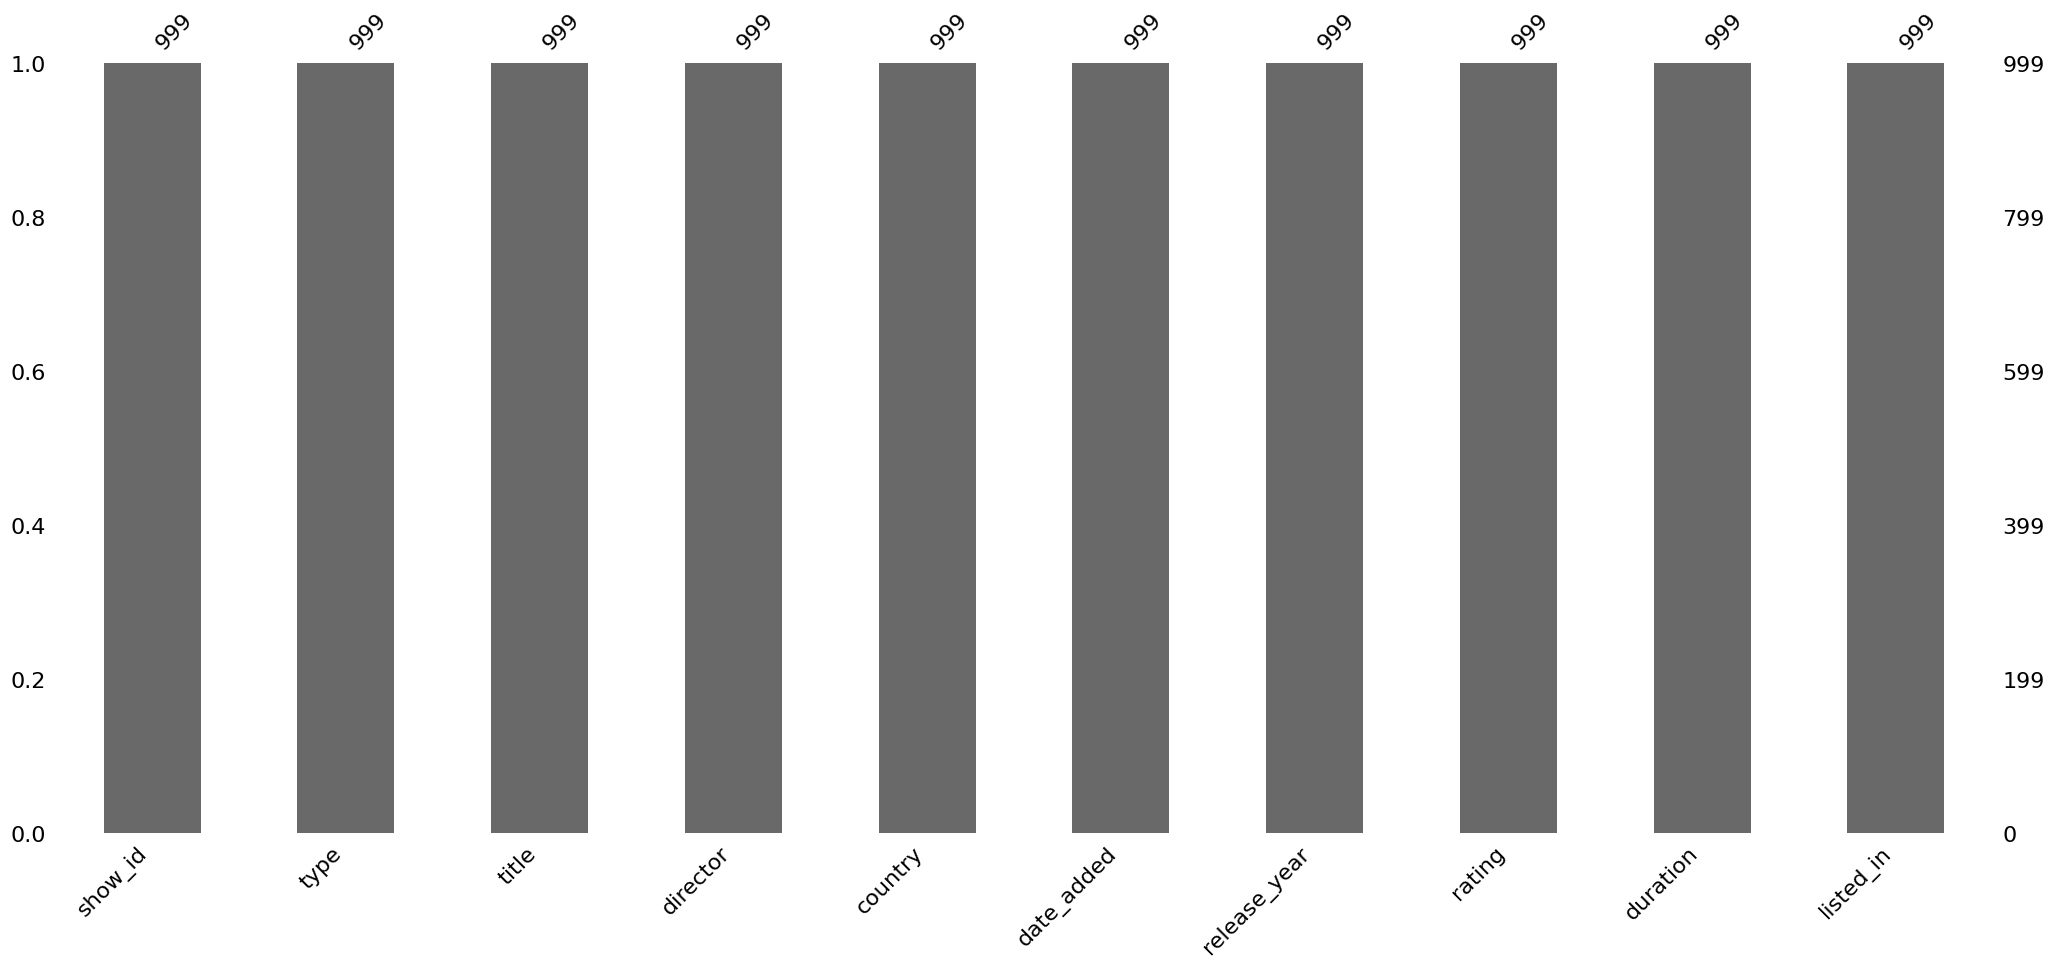

In [18]:
# Traitement global des données manquantes
critical_columns = ['director', 'country']
pandas_df = pandas_df.dropna(subset=critical_columns)  # Suppression ciblée des lignes critiques

# Imputation conditionnelle
pandas_df['country'] = pandas_df.groupby('listed_in')['country'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown country')
)
pandas_df['duration'] = pandas_df['duration'].fillna(
    pandas_df['type'].apply(lambda x: 'Unknown duration' if x == 'Movie' else 'Unknown')
)
pandas_df['director'] = pandas_df['director'].fillna('Unknown director')

# Visualisation post-traitement
msno.bar(pandas_df)
plt.show()

## Intégration transformations TP1 au TP2

### Modification du format de date_added

In [24]:
# Conversion de la colonne 'date_added' au format 'yyyy-mm-dd' en Pandas
pandas_df['date_added'] = pd.to_datetime(pandas_df['date_added'], errors='coerce')
pandas_df['date_added'] = pandas_df['date_added'].dt.strftime('%Y-%m-%d')

# Reconvertir le DataFrame Pandas en DataFrame PySpark
df_spark = spark.createDataFrame(pandas_df)

df_spark.show(truncate=False)

+-------+-------+--------------------------------------------------------------+-------------------------------+--------------+----------+------------+------+--------+-----------------------------------------------------------------+
|show_id|type   |title                                                         |director                       |country       |date_added|release_year|rating|duration|listed_in                                                        |
+-------+-------+--------------------------------------------------------------+-------------------------------+--------------+----------+------------+------+--------+-----------------------------------------------------------------+
|s939   |Movie  |Motu Patlu in the Game of Zones                               |Suhas Kadav                    |India         |2021-05-01|2019        |TV-Y7 |87 min  |Children & Family Movies, Comedies, Music & Musicals             |
|s913   |Movie  |The Circle - The Afterparty                    

### Affiche le pourcentage de répartition des films et séries TV

In [41]:
from pyspark.sql import functions as F

# Filtre un type incorrect apparaissant lors du tri
df = df.filter(df['type'] != 'William Wyler')

# Compter le nombre d'occurrences de chaque type
df_type_count = df.groupBy("type").count()

total_count = df.count()

# Calculer le pourcentage de chaque type
df_percentage = df_type_count.withColumn(
    "percentage",
    F.round((F.col("count") / total_count) * 100, 1)
)

df_percentage.show()

+-------+-----+----------+
|   type|count|percentage|
+-------+-----+----------+
|TV Show| 2664|      30.3|
|  Movie| 6126|      69.7|
+-------+-----+----------+

